In [96]:
import re
import pandas as pd
from tqdm import tqdm
from multiprocess import Pool
from functools import partial
import matplotlib.pyplot as plt
import multiprocess as mp

In [161]:
keywords = [
    "made in america", "made in u.s.", "made in us", # made in usa and made in us overlap
    "american made", "usa made", "u.s. made", "us made",
    "buy american", "buy usa", "buy america",
    "support america", "support usa", "support u.s.",
    "patriot",
    "choose american", "choose usa", "choose u.s.", "choose america",
    "national pride",
    "usa based", "america based", "american based", "us based", "u.s. based",
    "usa produced", "america produced", "american produced", "us produced", "u.s. produced",
    "usa manufactured", "america manufactured", "american manufactured", "us manufactured", "u.s. manufactured",
    "american worker", "american job",
    "veteran owned", "veteran founded", "founded by veteran",
    "handcrafted in america", "handcrafted in usa", "handcrafted in u.s.", "handcrafted in us",
    "crafted in america", "crafted in u.s.", "crafted in us", # removed "crafted in the usa" due to overlap with crafted in the US
    "america heritage", "america tradition", "america value",
    "icon of america", "icon of usa", "icon of u.s.",
    "america manufactur", "u.s. manufactur"
]

In [98]:
df_one = pd.read_csv("buy_usa_second_round_with_additional_firms.csv")
# df_one.drop(df_one.columns[:14], axis=1, inplace=True)
# df_one.tail()

C:\Users\theal\AppData\Local\Temp\ipykernel_23768\939587886.py:1: DtypeWarning: Columns (189,229,268,276,278,284,286,297,302,313,315,323,324,326,330,339) have mixed types. Specify dtype option on import or set low_memory=False.
  df_one = pd.read_csv("buy_usa_second_round_with_additional_firms.csv")


In [99]:
df_two = pd.read_csv("about_us_second_round_with_additional_firms.csv")
# df_two.drop(df_two.columns[:14], axis=1, inplace=True)
# df_two.head()

C:\Users\theal\AppData\Local\Temp\ipykernel_23768\1597471847.py:1: DtypeWarning: Columns (276,282,297,302,313,315,323,324,326,330,335,339) have mixed types. Specify dtype option on import or set low_memory=False.
  df_two = pd.read_csv("about_us_second_round_with_additional_firms.csv")


In [100]:
df_three = pd.read_csv("company_website_second_round_with_additional_firms.csv")
# df_three.drop(df_three.columns[:14], axis=1, inplace=True)
# df_three.shape

C:\Users\theal\AppData\Local\Temp\ipykernel_23768\3451373398.py:1: DtypeWarning: Columns (300,304,325,328) have mixed types. Specify dtype option on import or set low_memory=False.
  df_three = pd.read_csv("company_website_second_round_with_additional_firms.csv")


In [101]:
df_one.shape

(5358, 345)

In [102]:
df_two.shape

(5358, 345)

In [103]:
df_three.shape

(5189, 339)

In [104]:
def filter_columns(df):
    pattern = r"^\d{4}-\d{2}$"  # Regex to match the YYYY-MM format
    # Keep 'std_name' and any other column that matches the date format
    filtered_columns = ['std_name'] + [col for col in df.columns if re.match(pattern, col)]
    return df[filtered_columns]

# Apply the column filter to each DataFrame
df_one = filter_columns(df_one)
df_two = filter_columns(df_two)
df_three = filter_columns(df_three)

In [105]:
df_one = df_one.drop_duplicates(subset='std_name', keep='first').reset_index(drop=True)
df_two = df_two.drop_duplicates(subset='std_name', keep='first').reset_index(drop=True)
df_three = df_three.drop_duplicates(subset='std_name', keep='first').reset_index(drop=True)

# Find the intersection of 'std_name' across all DataFrames
common_std_names = set(df_one['std_name']) & set(df_two['std_name']) & set(df_three['std_name'])

# Filter each DataFrame to only include rows with 'std_name' in the intersection
df_one = df_one[df_one['std_name'].isin(common_std_names)].reset_index(drop=True)
df_two = df_two[df_two['std_name'].isin(common_std_names)].reset_index(drop=True)
df_three = df_three[df_three['std_name'].isin(common_std_names)].reset_index(drop=True)

# Sort the DataFrames by 'std_name' to align them
df_one = df_one.sort_values(by='std_name').reset_index(drop=True)
df_two = df_two.sort_values(by='std_name').reset_index(drop=True)
df_three = df_three.sort_values(by='std_name').reset_index(drop=True)

if (df_one['std_name'].equals(df_two['std_name']) and df_two['std_name'].equals(df_three['std_name'])):
    print("std_name matches across all dataframes.")
    std_name_column = df_one['std_name'].copy()
else:
    print("std_name does not match across all dataframes.")
    
df_one = df_one.drop(columns=['std_name'])
df_two = df_two.drop(columns=['std_name'])
df_three = df_three.drop(columns=['std_name'])

std_name matches across all dataframes.


In [116]:
std_name_column

0         11industries
1       11wellsspirits
2             14throse
3              1620usa
4          1803candles
             ...      
5184    zootilitytools
5185            zpacks
5186             zukes
5187             zuzii
5188          àlaboard
Name: std_name, Length: 5189, dtype: object

In [106]:
df_three.shape

(5189, 325)

In [107]:
df_two.shape

(5189, 325)

In [108]:
df_one.shape

(5189, 325)

In [109]:
assert df_one.shape == df_two.shape == df_three.shape, "DataFrames must have the same shape"

In [136]:
def count_keywords_in_cells(cells, keywords):
    return sum(keyword.lower() in str(cell).lower() for cell in cells for keyword in keywords)

def process_df(df, keywords):
    count_df = pd.DataFrame(index=df.index, columns=df.columns).fillna(0)
    for index, row in df.iterrows():
        previous_count = 0
        for col in reversed(df.columns):
            cell_value = row[col]
            count = count_keywords_in_cells([cell_value], keywords)
            
            # If count is zero but the previous count is greater than zero, carry over the previous count
            if count == 0 and previous_count > 0:
                count_df.at[index, col] = previous_count
            else:
                count_df.at[index, col] = count
                previous_count = count  # Update the previous count if it's greater than zero
                
    return count_df



# Process each DataFrame individually
count_df_one = process_df(df_one, keywords)
count_df_two = process_df(df_two, keywords)
count_df_three = process_df(df_three, keywords)

# # Combine the counts by summing corresponding cells
final_counts = count_df_one.add(count_df_two, fill_value=0).add(count_df_three, fill_value=0)

C:\Users\theal\AppData\Local\Temp\ipykernel_23768\1747922480.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  count_df = pd.DataFrame(index=df.index, columns=df.columns).fillna(0)
C:\Users\theal\AppData\Local\Temp\ipykernel_23768\1747922480.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  count_df = pd.DataFrame(index=df.index, columns=df.columns).fillna(0)
C:\Users\theal\AppData\Local\Temp\ipykernel_23768\1747922480.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Ca

In [140]:
# Assign the company names back to the final_counts DataFrame
final_counts.reset_index(drop=True, inplace=True)

# Now assign the Company column
final_counts['Company'] = std_name_column.values

cols = ['Company'] + [col for col in final_counts.columns if col != 'Company']
final_counts = final_counts[cols]

C:\Users\theal\AppData\Local\Temp\ipykernel_23768\1259610835.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final_counts['Company'] = std_name_column.values


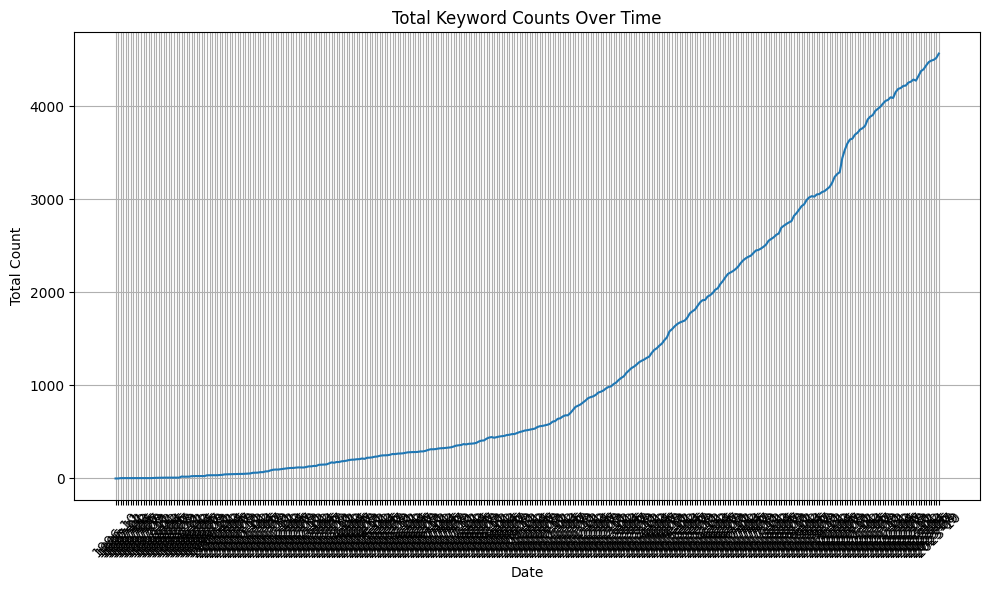

In [144]:
data_columns = final_counts.columns[1:]

# Reverse the column order
final_counts_reversed = final_counts[data_columns[::-1]]

# Sum up all the rows for each column to create a single series
summed_series = final_counts_reversed.sum()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(summed_series.index, summed_series.values)

plt.title('Total Keyword Counts Over Time')
plt.xlabel('Date')
plt.ylabel('Total Count')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [153]:
final_counts.head(50)

,Company,2023-10,2023-09,2023-08,2023-07,2023-06,2023-05,2023-04,2023-03,2023-02,...,1997-07,1997-06,1997-05,1997-04,1997-03,1997-02,1997-01,1996-12,1996-11,1996-10
0,11industries,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,11wellsspirits,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,14throse,3,3,3,3,3,3,3,3,3,...,0,0,0,0,0,0,0,0,0,0
3,1620usa,5,5,5,5,5,5,5,5,5,...,0,0,0,0,0,0,0,0,0,0
4,1803candles,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
5,1888mills,4,4,4,4,4,4,4,4,1,...,0,0,0,0,0,0,0,0,0,0
6,1919cookware,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
7,20degeesbelow,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
8,21degreenorth,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,270smokers,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [148]:
final_counts.to_csv('MIU_Panel_grouped_keywords.csv')